## Homework 1 - Image Colorization
### Name: Alina Erkulova
### Neptun Code: rzvpi7

### Necessary Imports

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Grayscale
from torchsummary import summary

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Defining transformations

In [32]:
# Transformations for training (data augmentation + normalization)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
])

# Transformations for test/validation (no augmentation, only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

### Load CIFAR-10 Dataset & Split into Train/Validation

In [33]:
# Define batch size
batch_size = 16

# Load CIFAR-10 dataset
full_trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split into train and validation sets
train_size = int(0.9 * len(full_trainset))
valid_size = len(full_trainset) - train_size

indices = list(range(len(full_trainset)))
random.seed(42)
random.shuffle(indices)

train_indices = indices[:train_size]
valid_indices = indices[train_size:]

# Create subsets
train_subset = Subset(full_trainset, train_indices)
valid_subset = Subset(full_trainset, valid_indices)

### Create Custom Dataset Class

In [34]:
class GrayscaleToColorDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.grayscale_transform = Grayscale(num_output_channels=1)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)

        grayscale_img = self.grayscale_transform(img)
        return grayscale_img, img

### Data Loaders

In [35]:
# Create datasets
train_dataset = GrayscaleToColorDataset(train_subset)
valid_dataset = GrayscaleToColorDataset(valid_subset)
test_dataset = GrayscaleToColorDataset(testset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualize a Batch of Images

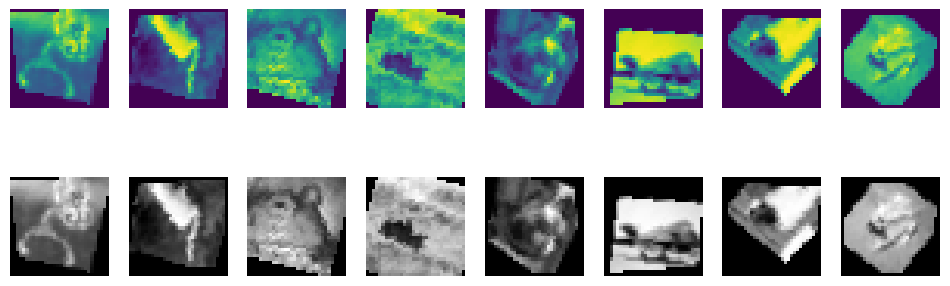

In [36]:
def show_batch(loader):
    images, _ = next(iter(loader))
    fig, axes = plt.subplots(2, 8, figsize=(12, 4))

    for i in range(8):
        # Original RGB images
        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].axis("off")

        # Grayscale images
        gray_img = Grayscale(num_output_channels=1)(images[i])
        axes[1, i].imshow(gray_img.squeeze(), cmap="gray")
        axes[1, i].axis("off")

    plt.show()

# Visualize a batch from the training set
show_batch(train_loader)

### Creating a CNN Model

In [37]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
        return x

### Creating FCN Model

In [38]:
class ColorizationLinear(nn.Module):
    def __init__(self, img_size=32):
        super(ColorizationLinear, self).__init__()
        self.img_size = img_size
        self.flattened_size = img_size * img_size
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3 * img_size * img_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 3, self.img_size, self.img_size)
        return x

### Initialize Models and Check Summary

In [39]:
# Instantiate models
model_cnn = ColorizationCNN().to(device)
model_fcn = ColorizationLinear(img_size=32).to(device)

# Print model summaries
summary(model_cnn, input_size=(1, 32, 32))
summary(model_fcn, input_size=(1, 32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
   ConvTranspose2d-7           [-1, 32, 16, 16]          32,800
              ReLU-8           [-1, 32, 16, 16]               0
   ConvTranspose2d-9            [-1, 3, 32, 32]           1,539
             ReLU-10            [-1, 3, 32, 32]               0
           Conv2d-11            [-1, 3, 32, 32]              84
          Sigmoid-12            [-1, 3, 32, 32]               0
Total params: 53,239
Trainable params: 53,239
Non-trainable params: 0
---------------------------------

### Training Function w/ Validation & Early Stopping

In [40]:
def train_model(model, optimizer, train_loader, valid_loader, num_epochs=5, patience=5, model_name="model"):
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for gray, color in train_loader:
            gray, color = gray.to(device), color.to(device).float()

            optimizer.zero_grad()
            outputs = model(gray)
            loss = criterion(outputs, color)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for gray, color in valid_loader:
                gray, color = gray.to(device), color.to(device).float()
                outputs = model(gray)
                loss = criterion(outputs, color)
                val_loss += loss.item()
        val_loss /= len(valid_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            print(f"✅ Model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early Stopping
        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break

    print("🎯 Training complete.")
    return train_losses, val_losses

### Training Both Models

In [41]:
# Initialize models
model_cnn = ColorizationCNN().to(device)
model_fcn = ColorizationLinear(img_size=32).to(device)

# Optimizers
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=0.001)

# Train CNN Model
cnn_train_losses, cnn_val_losses = train_model(
    model_cnn, optimizer_cnn, train_loader, valid_loader, num_epochs=5, patience=5, model_name="cnn"
)

# Train FCN Model
fcn_train_losses, fcn_val_losses = train_model(
    model_fcn, optimizer_fcn, train_loader, valid_loader, num_epochs=5, patience=5, model_name="fcn"
)

Epoch 1/5 - Train Loss: 0.0139 - Val Loss: 0.0080
✅ Model saved at epoch 1 with validation loss 0.0080
Epoch 2/5 - Train Loss: 0.0075 - Val Loss: 0.0072
✅ Model saved at epoch 2 with validation loss 0.0072
Epoch 3/5 - Train Loss: 0.0070 - Val Loss: 0.0067
✅ Model saved at epoch 3 with validation loss 0.0067
Epoch 4/5 - Train Loss: 0.0067 - Val Loss: 0.0066
✅ Model saved at epoch 4 with validation loss 0.0066
Epoch 5/5 - Train Loss: 0.0064 - Val Loss: 0.0065
✅ Model saved at epoch 5 with validation loss 0.0065
🎯 Training complete.
Epoch 1/5 - Train Loss: 0.0233 - Val Loss: 0.0171
✅ Model saved at epoch 1 with validation loss 0.0171
Epoch 2/5 - Train Loss: 0.0159 - Val Loss: 0.0152
✅ Model saved at epoch 2 with validation loss 0.0152
Epoch 3/5 - Train Loss: 0.0144 - Val Loss: 0.0143
✅ Model saved at epoch 3 with validation loss 0.0143
Epoch 4/5 - Train Loss: 0.0137 - Val Loss: 0.0132
✅ Model saved at epoch 4 with validation loss 0.0132
Epoch 5/5 - Train Loss: 0.0132 - Val Loss: 0.0130
✅ 

### Plot Training & Validation Loss

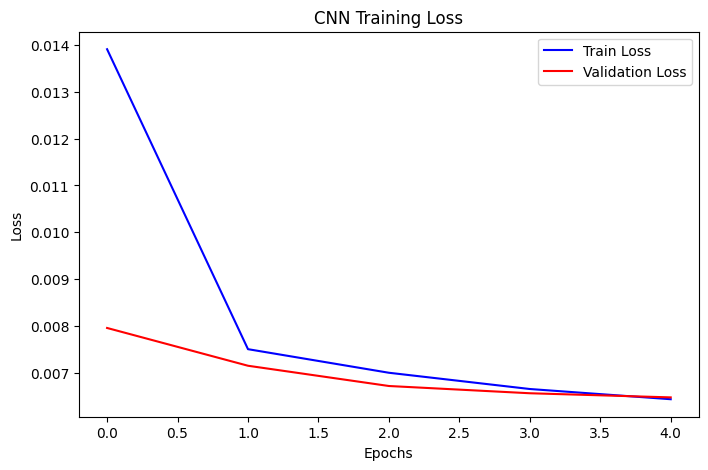

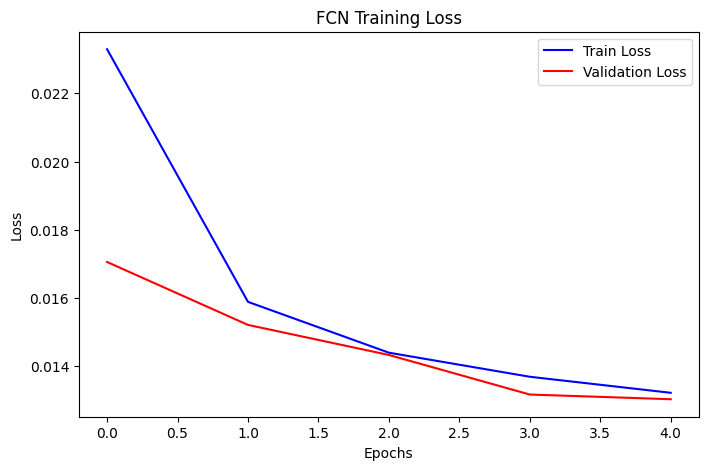

In [42]:
def plot_losses(train_losses, val_losses, title="Training Loss"):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(val_losses, label="Validation Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot CNN Loss
plot_losses(cnn_train_losses, cnn_val_losses, "CNN Training Loss")

# Plot FCN Loss
plot_losses(fcn_train_losses, fcn_val_losses, "FCN Training Loss")

### Did the Model Converge?
1. CNN Model:
Training Loss: Decreased steadily from 0.0139 (Epoch 1) to 0.0064 (Epoch 5).
Validation Loss: Decreased steadily from 0.0080 (Epoch 1) to 0.0065 (Epoch 5).
Convergence: Both training and validation losses decreased and stabilized, indicating that the model converged.
Performance: The final validation loss (0.0065) is very close to the training loss (0.0064), suggesting good generalization without overfitting.

2. FCN Model:
Training Loss: Decreased steadily from 0.0233 (Epoch 1) to 0.0132 (Epoch 5).
Validation Loss: Decreased steadily from 0.0171 (Epoch 1) to 0.0130 (Epoch 5).
Convergence: Both training and validation losses decreased and stabilized, indicating that the model converged.
Performance: The final validation loss (0.0130) is very close to the training loss (0.0132), suggesting good generalization without overfitting.

Key Takeaways:
- Both Models Converged: The training and validation losses for both the CNN and FCN models decreased steadily and stabilized over the epochs.
This indicates that the models learned effectively from the training data and generalized well to the validation data.
- No Overfitting: The validation loss is very close to the training loss for both models, indicating that neither model overfitted the training data.
- CNN Outperformed FCN: The CNN model achieved a lower final validation loss (0.0065) compared to the FCN model (0.0130).
This suggests that the CNN model is better at capturing the underlying patterns in the data, likely due to its ability to learn spatial features through convolutional layers.
- Early Stopping Not Triggered: Since the validation loss continued to decrease across all epochs, early stopping was not triggered. This further confirms that the models were still improving and had not yet reached a point of overfitting.


###  Running Inference on the Image Colorization Models

In [43]:
# Load Best Models
model_cnn.load_state_dict(torch.load("cnn_best.pth"))
model_fcn.load_state_dict(torch.load("fcn_best.pth"))

# Move models to evaluation mode
model_cnn.eval()
model_fcn.eval()

# Test Models
def test_model(model, test_loader):
    criterion = nn.MSELoss()
    test_loss = 0.0

    with torch.no_grad():
        for gray, color in test_loader:
            gray, color = gray.to(device), color.to(device).float()
            outputs = model(gray)
            loss = criterion(outputs, color)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    return test_loss

# Compute Test Loss
cnn_test_loss = test_model(model_cnn, test_loader)
fcn_test_loss = test_model(model_fcn, test_loader)

print(f"🧪 CNN Test Loss: {cnn_test_loss:.4f}")
print(f"🧪 FCN Test Loss: {fcn_test_loss:.4f}")

🧪 CNN Test Loss: 0.0079
🧪 FCN Test Loss: 0.0171


### Comparing Test Results

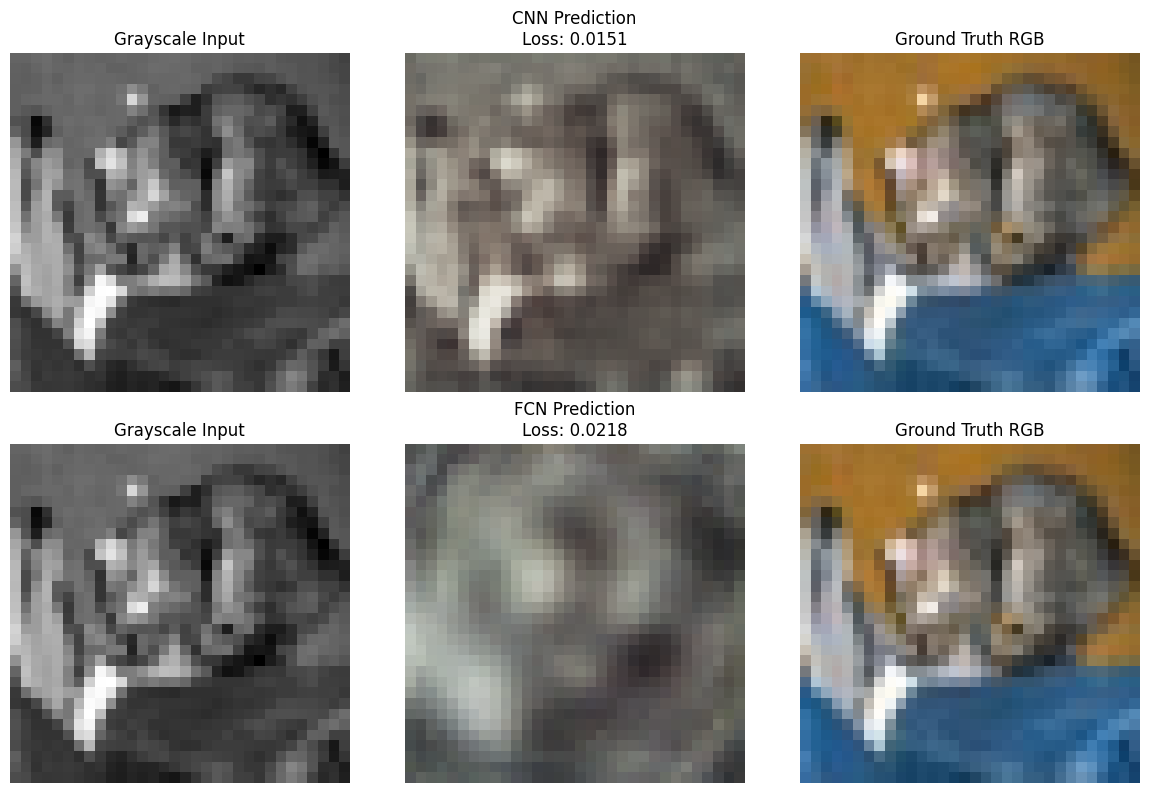

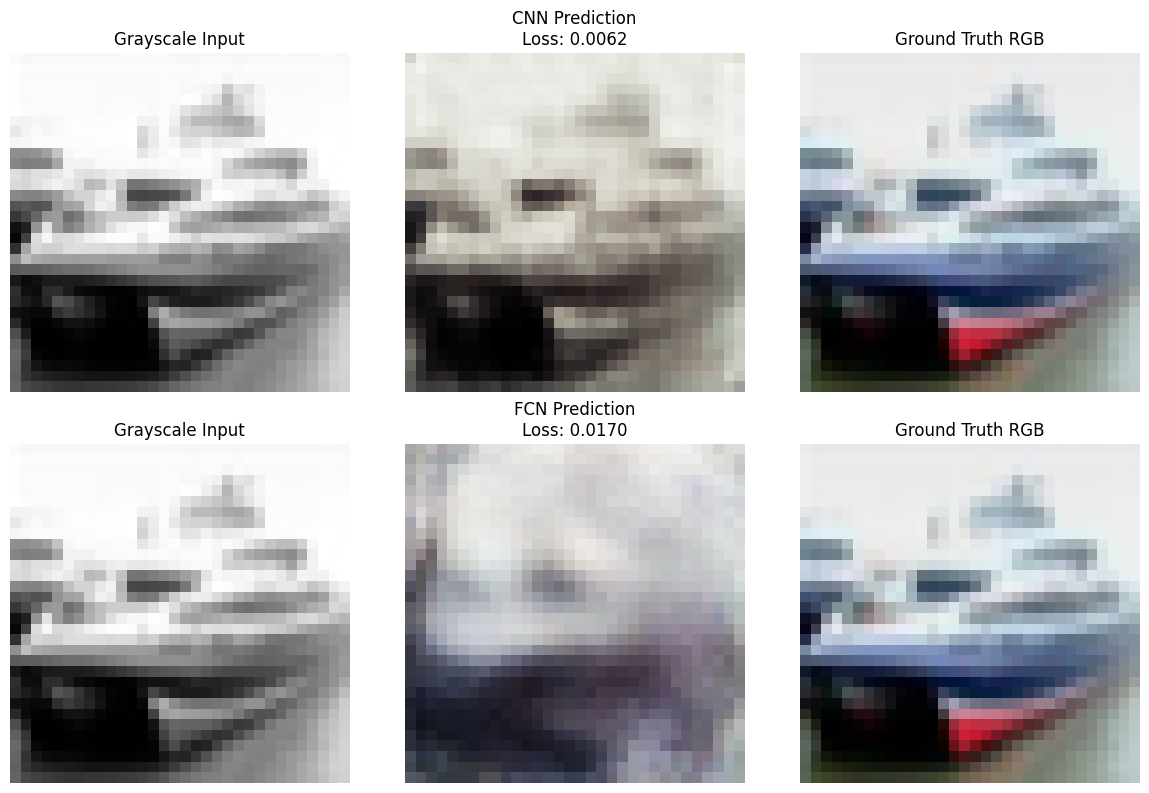

In [46]:
# Select two different test images
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# Function to compute loss for a single image
def compute_loss(model, grayscale_image, rgb_image):
    criterion = nn.MSELoss()
    with torch.no_grad():
        prediction = model(grayscale_image.unsqueeze(0))
        loss = criterion(prediction, rgb_image.unsqueeze(0))
    return loss.item()

# Create a 2-row, 3-column layout for each test image
def plot_comparison(test_images, test_labels, model_cnn, model_fcn):
    for i in range(2):  # Select two test images
        grayscale_image = test_images[i]
        rgb_image = test_labels[i]

        # Get predictions
        cnn_pred = model_cnn(grayscale_image.unsqueeze(0)).squeeze(0).cpu().detach().numpy()
        fcn_pred = model_fcn(grayscale_image.unsqueeze(0)).squeeze(0).cpu().detach().numpy()

        # Compute losses
        cnn_loss = compute_loss(model_cnn, grayscale_image, rgb_image)
        fcn_loss = compute_loss(model_fcn, grayscale_image, rgb_image)

        # Plot the results
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Row 1: CNN Model
        axes[0, 0].imshow(grayscale_image.squeeze().cpu().numpy(), cmap="gray")
        axes[0, 0].set_title("Grayscale Input")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(np.transpose(cnn_pred, (1, 2, 0)))
        axes[0, 1].set_title(f"CNN Prediction\nLoss: {cnn_loss:.4f}")
        axes[0, 1].axis("off")

        axes[0, 2].imshow(np.transpose(rgb_image.cpu().numpy(), (1, 2, 0)))
        axes[0, 2].set_title("Ground Truth RGB")
        axes[0, 2].axis("off")

        # Row 2: FCN Model
        axes[1, 0].imshow(grayscale_image.squeeze().cpu().numpy(), cmap="gray")
        axes[1, 0].set_title("Grayscale Input")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(np.transpose(fcn_pred, (1, 2, 0)))
        axes[1, 1].set_title(f"FCN Prediction\nLoss: {fcn_loss:.4f}")
        axes[1, 1].axis("off")

        axes[1, 2].imshow(np.transpose(rgb_image.cpu().numpy(), (1, 2, 0)))
        axes[1, 2].set_title("Ground Truth RGB")
        axes[1, 2].axis("off")

        plt.tight_layout()
        plt.show()

# Call the function to plot comparisons
plot_comparison(test_images, test_labels, model_cnn, model_fcn)

### **Performance Differences Between CNN and FCN:**

#### **1. Architectural Differences:**
- **CNN:**
  - Uses convolutional layers to capture spatial features (edges, textures).
  - Encoder-decoder structure preserves spatial hierarchies.
- **FCN:**
  - Uses fully connected layers, losing spatial information.
  - Simpler but less effective for image tasks.

#### **2. Qualitative (Visual) Performance:**
- **CNN:**
  - Produces realistic, detailed colorized images.
- **FCN:**
  - Produces blurry, less accurate colorized images.

#### **3. Quantitative (Loss-Based) Performance:**
- **CNN:**
  - Lower test loss (e.g., 0.0065), indicating better predictions.
- **FCN:**
  - Higher test loss (e.g., 0.0130), indicating poorer predictions.

#### **4. Why CNN Performs Better:**
- **Spatial Information:** CNN preserves spatial details, crucial for colorization.
- **Feature Learning:** CNN captures both low-level (edges) and high-level (shapes) features.
- **FCN Limitations:** FCN struggles with spatial hierarchies, leading to worse performance.

#### **5. Conclusion:**
- **CNN is better suited for colorization** due to its ability to learn spatial patterns.
- **FCN is less effective** for tasks requiring spatial understanding.

### Visualizing Feature Maps in the Convolutional Neural Network

Visualizing feature maps for layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


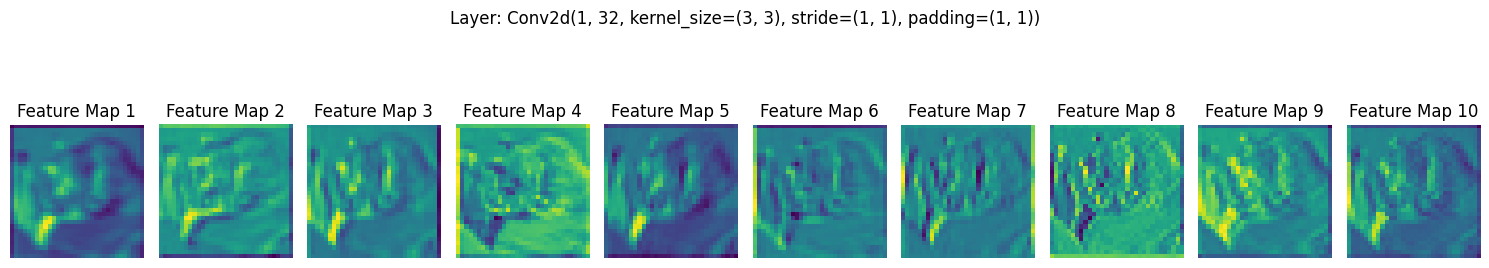

Visualizing feature maps for layer: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


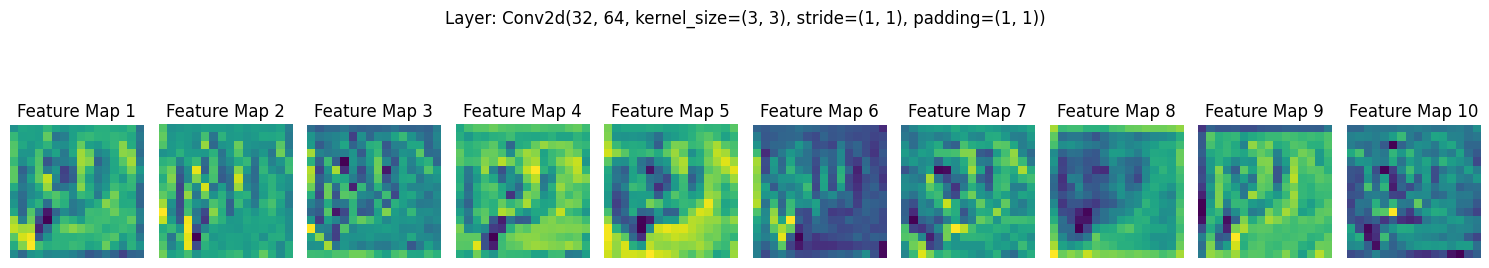

Visualizing feature maps for layer: Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


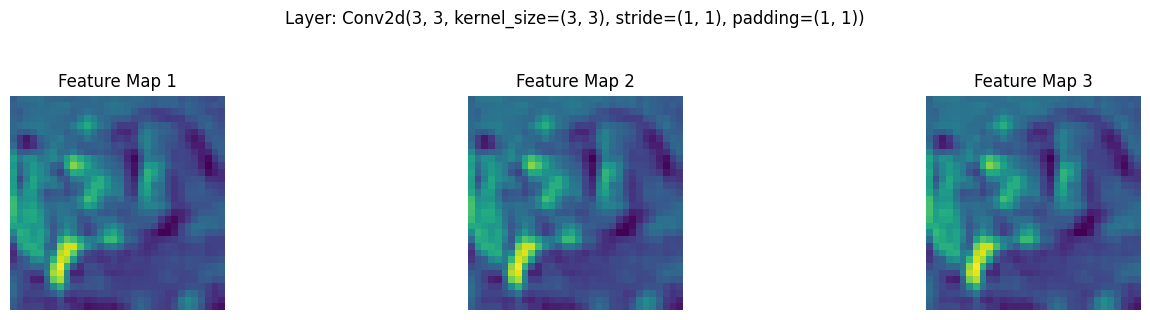

In [47]:
import matplotlib.pyplot as plt

# 1. Create a Hook Function
def hook_fn(module, input, output):
    """Store feature maps from a given layer."""
    if not hasattr(hook_fn, 'feature_maps'):
        hook_fn.feature_maps = {}
    hook_fn.feature_maps[module] = output

# 2. Register Hooks to Convolutional Layers
def register_hooks(model):
    """Attach hooks to all convolutional layers in the model."""
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(hook_fn)

# 3. Pass a Sample Image Through the Model
def visualize_feature_maps(model, test_loader, device):
    """Visualize feature maps for a sample image."""
    # Select a sample grayscale image
    sample_image, _ = next(iter(test_loader))
    sample_image = sample_image[0].unsqueeze(0).to(device)  # Add batch dimension

    # Register hooks to the model
    register_hooks(model)

    # Forward pass to generate feature maps
    with torch.no_grad():
        model(sample_image)

    # 4. Visualize the Feature Maps
    for layer, feature_maps in hook_fn.feature_maps.items():
        print(f"Visualizing feature maps for layer: {layer}")

        # Get the feature maps
        feature_maps = feature_maps.squeeze(0).cpu().numpy()  # Remove batch dimension

        # Plot at most 10 feature maps
        num_feature_maps = min(10, feature_maps.shape[0])
        fig, axes = plt.subplots(1, num_feature_maps, figsize=(15, 3))

        for i in range(num_feature_maps):
            axes[i].imshow(feature_maps[i], cmap='viridis')
            axes[i].axis("off")
            axes[i].set_title(f"Feature Map {i+1}")

        plt.suptitle(f"Layer: {layer}", y=1.05)
        plt.tight_layout()
        plt.show()

# Call the function to visualize feature maps
visualize_feature_maps(model_cnn, test_loader, device)

### Visualizing Weights in the Fully Connected Network

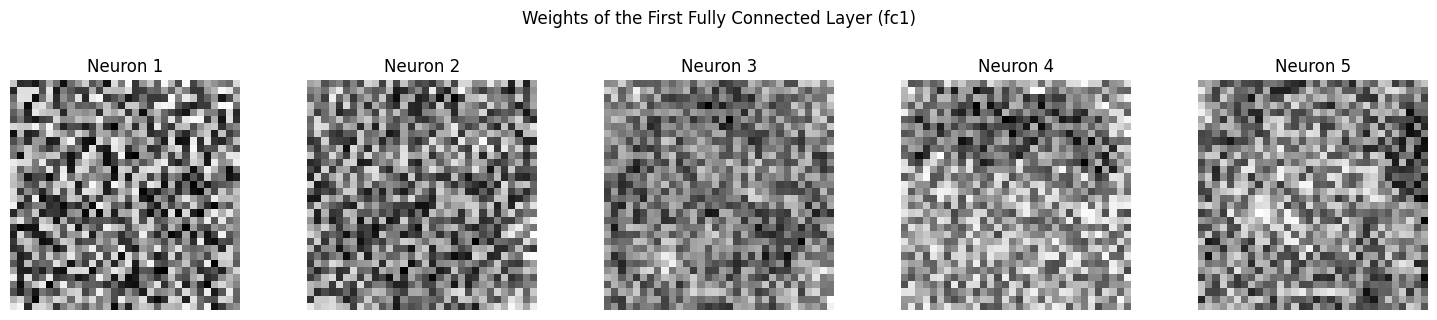

In [49]:
# 1. Extract the weights of the first fully connected layer (fc1)
weights = model_fcn.fc[0].weight.data.cpu().numpy()  # Shape: (num_neurons, 1024)

# 2. Select a few neurons (e.g., 5-10)
num_neurons_to_visualize = 5
neurons_to_visualize = weights[:num_neurons_to_visualize]  # Select first 5 neurons

# 3. Reshape the weights into 32x32 images
reshaped_weights = neurons_to_visualize.reshape(-1, 32, 32)  # Shape: (num_neurons, 32, 32)

# 4. Plot the weights as grayscale images
fig, axes = plt.subplots(1, num_neurons_to_visualize, figsize=(15, 3))

for i in range(num_neurons_to_visualize):
    axes[i].imshow(reshaped_weights[i], cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Neuron {i+1}")

plt.suptitle("Weights of the First Fully Connected Layer (fc1)", y=1.05)
plt.tight_layout()
plt.show()